# Lines Detection

In [1]:
import numpy as np
import imageio
import math

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
from matplotlib import cm

## Project Functions

In [801]:
# helpers
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def theta2gradient(theta):
    return np.cos(theta) / np.sin(theta)


def rho2intercept(theta, rho):
    return rho / np.sin(theta)

def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
def peak_votes(accumulator, thetas, rhos):
    """ Finds the max number of votes in the hough accumulator """
    idx = np.argmax(accumulator)
    rho = rhos[idx // accumulator.shape[1]]
    theta = thetas[idx % accumulator.shape[1]]

    return idx, theta, rho         

### Hough Transformation Methods

In [890]:
def hough_linee(img, angle_step=1, lines_are_white=True, value_threshold=1):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def hough_trans(image):
    """
    Hough transform for lines
    Input:
    image - 2D binary image with nonzeros representing edges
    Returns:
    h - 2D array of the hough transform accumulator
    thetas - array of angles used in computation, in radians.
    rhos   - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # set constants
    angle_step = 1
    n_thetas = 180
    width, height = image.shape
    diag_len = math.ceil(math.sqrt(width * width + height * height))
    
    # construct array structures
    thetas = np.linspace(-np.pi/2, np.pi/2, n_thetas)
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
    # dx, dy = np.gradient(image)
    dx = np.gradient(image, axis=0)
    dy = np.gradient(image, axis=1)
    H = np.zeros((diag_len * 2, n_thetas + 1), dtype=np.uint8)
    
    # hough transformation
    for y in range(height):
        for x in range(width):
            if dx[x, y] != 0:
                theta = np.arctan2(dy[x, y], dx[x, y])
                angl =  np.rad2deg(-theta)
                rho = diag_len + (x * np.cos(theta) + y * np.sin(theta))
                H[math.ceil(rho), math.ceil(angl)] += 1

    return H, thetas, rhos

## Test on images

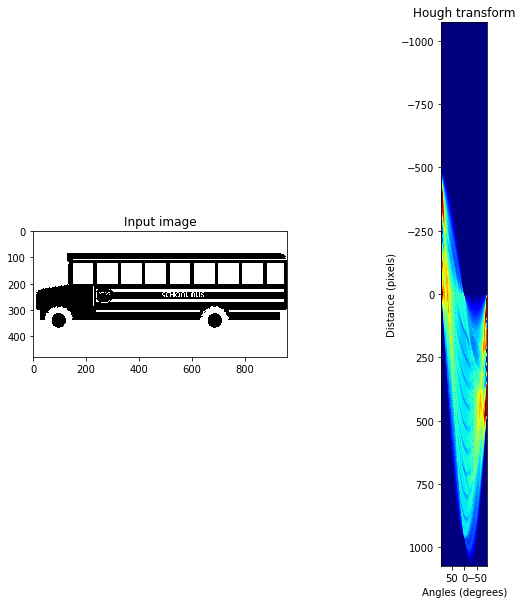

In [889]:
image_path = 'data/binary_crosses.png'
# image_path = 'data/stairs.jpg'
# image_path = 'data/tenis_court.jpg'
# image_path = 'data/tenis_court2.jpg'
image_path = 'data/bus.png'

# gray scale pre-processing
image = imageio.imread(image_path)
if image.ndim == 3:
    image = rgb2gray(image)

thr_val = threshold_otsu(image)
img_b = (image < thr_val).astype(np.uint8)

# image = np.zeros((100, 100))
# idx = np.arange(25, 75)
# image[idx[::-1], idx] = 255
# image[idx, idx] = 255
    
# Hough Transformation
# h, thetas, rhos = hough_linee(img_b, angle_step=1, lines_are_white=True, value_threshold=230)
# h, thetas, rhos = hough_linee(img_b, angle_step=1, lines_are_white=True, value_threshold=230)

h, thetas, rhos = hough_trans(img_b)

In [ ]:
ht, thetast, rhost = hough_line(img_b)
show_hough_line(img_b, ht, thetas, rhos)

In [878]:
ht.nonzero()

(array([ 595,  595,  595, ..., 2146, 2146, 2146]),
 array([  0,   1,   2, ..., 115, 116, 117]))

In [879]:
# h.nonzero()

In [880]:
idx = np.argmax(h)
h_max = h[idx // h.shape[1], idx % h.shape[1]]
threshold = .2 * max(h.shape)
threshold = 0.1 * h_max

cartezian_coords = list()

h_idxes = np.argwhere(h >= threshold)
polar_coords = [(rhos[r_idx], thetas[t_idx]) for r_idx, t_idx in h_idxes]
# cart_coords = [(theta2gradient(theta), rho2intercept(theta, rho)) for rho, theta in polar_coords]

In [881]:
# polar_coords

In [882]:
# polar_coords

In [883]:
len(polar_coords)

47

(0, 960) (269.66705575628924, 286.5175510166962) 245.6593121349773 -1.5707963267948966
(0, 960) (308.6912308007986, 325.54172606120557) 245.6593121349773 -1.5707963267948966
(0, 960) (-344.6604564508616, -344.66045645086155) 245.6593121349773 -1.5707963267948966
(0, 960) (110.56849595944338, 127.41899121985034) 245.6593121349773 -1.5707963267948966
(0, 960) (-124.55798789007918, -124.55798789007912) 245.6593121349773 -1.5707963267948966
(0, 960) (202.62552426956805, 219.47601952997502) 245.6593121349773 -1.5707963267948966
(0, 960) (88.55485875484828, 105.40535401525524) 245.6593121349773 -1.5707963267948966
(0, 960) (-221.60316721006052, -221.60316721006046) 245.6593121349773 -1.5707963267948966
(0, 960) (-260.62133209129, -260.62133209128996) 245.6593121349773 -1.5707963267948966
(0, 960) (231.64350058471598, 248.49399584512295) 245.6593121349773 -1.5707963267948966


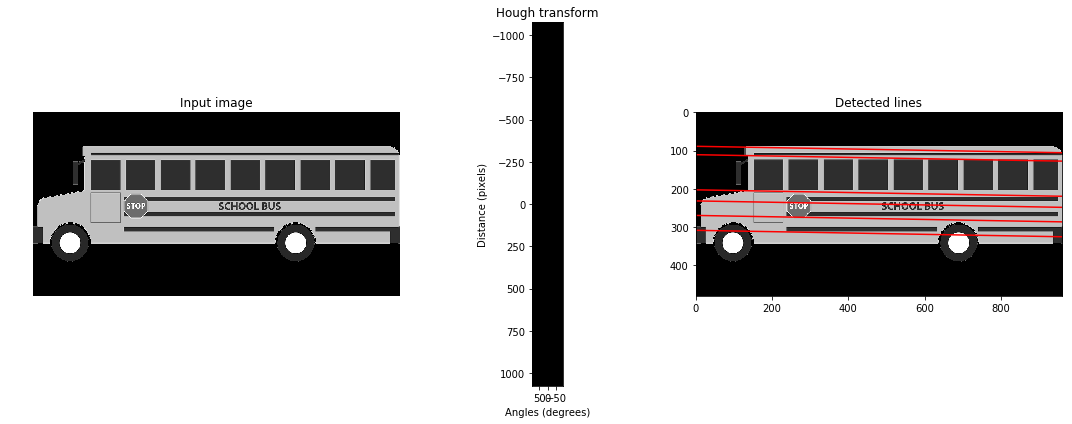

In [884]:
# Classic straight-line Hough transform
# h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(h,
             extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, thetas, rhos)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    print((0, image.shape[1]), (y0, y1), rho, theta)

# for rho, theta in polar_coords:
#     x1, x2 = 0, image.shape[1]
#     # rho = x * np.cos(theta) + y * np.sin(theta)    
#     y1 = (rho - x1 * np.cos(theta)) / np.sin(theta) 
#     y2 = (rho - x2 * np.cos(theta)) / np.sin(theta)
#     ax[2].plot((x1, x2), (y1, y2), '-r')
    
#     print('1', (x1, y1), (x2, y2), rho, np.rad2deg(theta))

# for m, b in cart_coords:
#     ax[2].plot((0, image.shape[1]), (m, b), '-r')


ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
# ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

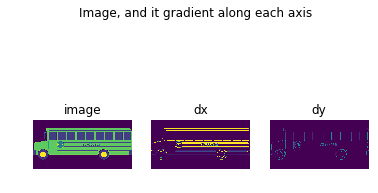

In [885]:
dx = np.gradient(image, axis=0)
dy = np.gradient(image, axis=1)
# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(image)
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(dx)
ax.set_title("dx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(dy)
ax.set_title("dy")
plt.show()